In [152]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime

In [145]:
options = 'results=8000&timezone=America%2FSao_Paulo'
data = requests.get('https://api.thingspeak.com/channels/657211/feeds.json?'+options).content
feeds = json.loads(data)['feeds']
display(feeds[0])
display(feeds[-1])

{'created_at': '2019-07-12T12:02:38-03:00',
 'entry_id': 23131,
 'field1': None,
 'field2': None,
 'field3': '30.70',
 'field4': '66.00\r\n\r\n'}

{'created_at': '2019-07-19T11:43:19-03:00',
 'entry_id': 31130,
 'field1': None,
 'field2': None,
 'field3': '26.60',
 'field4': '53.00\r\n\r\n'}

In [146]:
df = pd.DataFrame.from_dict(feeds)
fields = [x for x in df.columns if x.startswith('field')]
for field in fields:
    df[field] = df[field].str.replace('\r\n','').astype(float)
df['created_at'] = pd.to_datetime(df['created_at'])

In [147]:
df.tail()

,created_at,entry_id,field1,field2,field3,field4
7995,2019-07-19 14:39:18,31126,NaN,NaN,27.2,51.0
7996,2019-07-19 14:40:48,31127,26.0,60.0,NaN,NaN
7997,2019-07-19 14:41:19,31128,NaN,NaN,26.9,52.0
7998,2019-07-19 14:42:49,31129,25.9,59.0,NaN,NaN
7999,2019-07-19 14:43:19,31130,NaN,NaN,26.6,53.0


In [111]:
df2 =  df.set_index('created_at').resample("5T").mean()[fields]

In [140]:
df_old = pd.read_pickle('data.pickle')
before = df_old.shape[0]
df_old = df_old.append(df2)
df_old.drop_duplicates(inplace=True)
after = df_old.shape[0]
' '.join(["added",str(after-before),"lines. Now, there are ",str(after),"lines."])

'added 0 lines. Now, there are  1875 lines.'

In [141]:
df_old.tail()

,field1,field2,field3,field4
created_at,,,,
2019-07-19 12:45:00,25.7,58.0,27.450000,51.500000
2019-07-19 12:50:00,25.7,56.0,26.966667,50.666667
2019-07-19 12:55:00,25.8,57.0,27.600000,51.000000
2019-07-19 13:00:00,25.6,57.0,27.766667,50.333333
2019-07-19 13:05:00,25.7,56.0,27.350000,50.000000


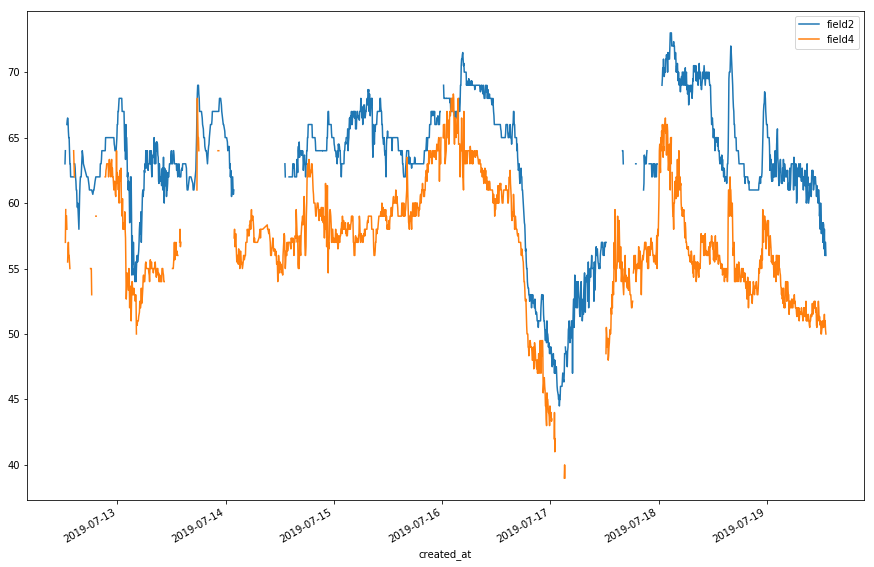

In [142]:
df_old[['field2','field4']].plot(figsize=(15,10),)

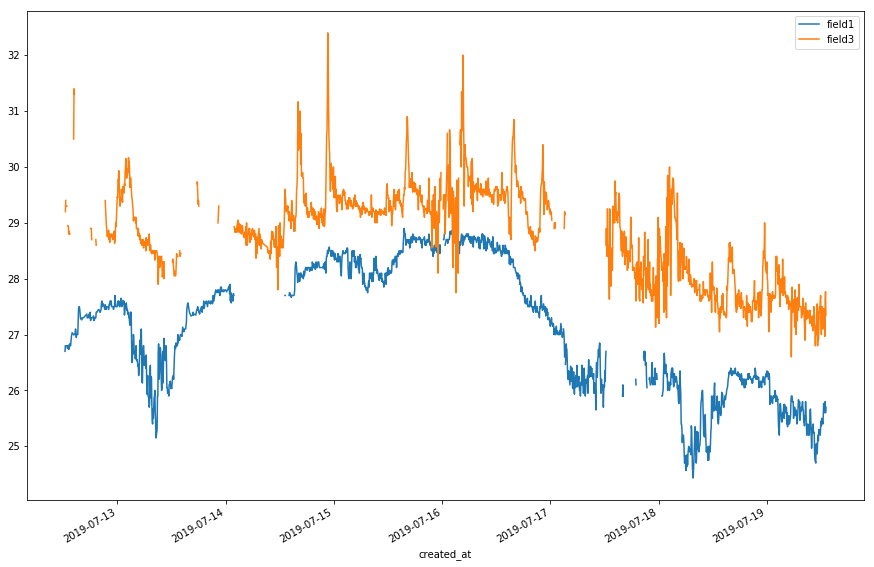

In [143]:
df_old[['field1','field3']].plot(figsize=(15,10))

In [128]:
df_old.to_pickle('data.pickle')

In [178]:
dfx = df_old.reset_index()
#dfx.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
dfx['date2'] = dfx['created_at'].dt.hour + dfx['created_at'].dt.minute/60 + dfx['created_at'].dt.second/3600
dfx.tail()

,created_at,field1,field2,field3,field4,date2,date_polar
1870,2019-07-19 12:45:00,25.7,58.0,27.450000,51.500000,12.750000,3.337942
1871,2019-07-19 12:50:00,25.7,56.0,26.966667,50.666667,12.833333,3.359759
1872,2019-07-19 12:55:00,25.8,57.0,27.600000,51.000000,12.916667,3.381575
1873,2019-07-19 13:00:00,25.6,57.0,27.766667,50.333333,13.000000,3.403392
1874,2019-07-19 13:05:00,25.7,56.0,27.350000,50.000000,13.083333,3.425209


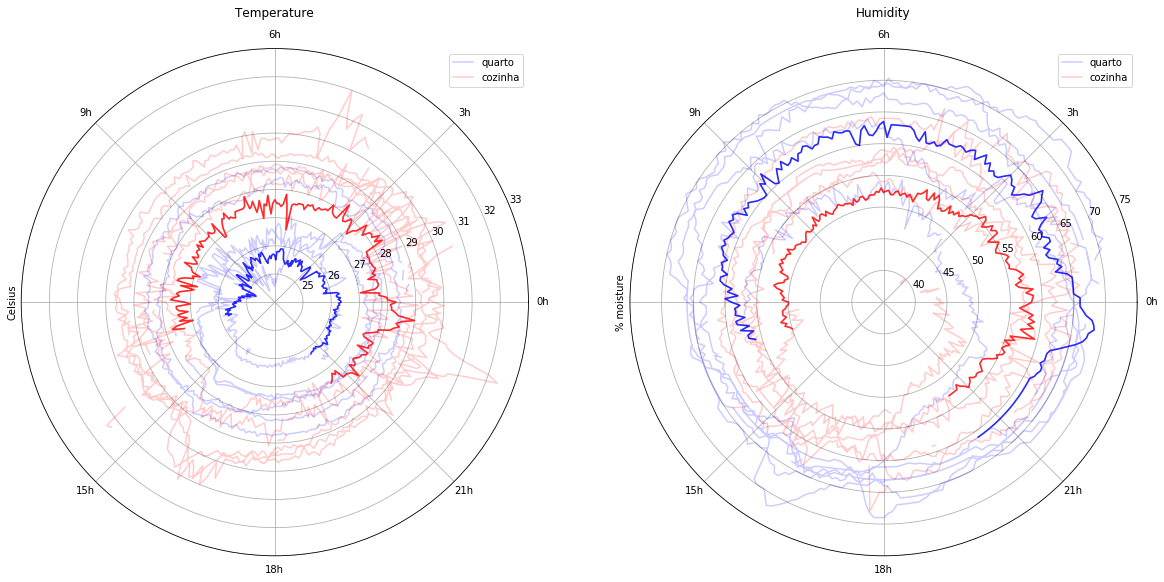

In [277]:
dfx['theta'] = dfx['date2']  * np.pi / 24. * 2
last = 200

fig = plt.figure(figsize=(20,30))

## Temperature
ax = fig.add_subplot(1,2,1,projection='polar')
ax.set_xticklabels(['0h', '3h', '6h', '9h', '', '15h', '18h', '21h'])
plt.title('Temperature')
plt.ylabel('Celsius')
ax.plot(dfx['theta'] , dfx['field1'], alpha=.2 ,color='blue' )
ax.plot(dfx['theta'] , dfx['field3'], alpha=.2,color='red' )
ax.plot(dfx['theta'][-last:] , dfx['field1'][-last:], alpha=.8,lw=1.6 ,color='blue')
ax.plot(dfx['theta'][-last:] , dfx['field3'][-last:], alpha=.8,lw=1.6 ,color='red' )
plt.ylim(24,33)
ax.legend(('quarto','cozinha'))

## Humidity
ax = fig.add_subplot(1,2,2,projection='polar')
ax.set_xticklabels(['0h', '3h', '6h', '9h', '', '15h', '18h', '21h'])
plt.title('Humidity')
plt.ylabel('% moisture')
ax.plot(dfx['theta'] , dfx['field2'], alpha=.2 ,color='blue' )
ax.plot(dfx['theta'] , dfx['field4'], alpha=.2,color='red' )
ax.plot(dfx['theta'][-last:] , dfx['field2'][-last:], alpha=.8,lw=1.6 ,color='blue')
ax.plot(dfx['theta'][-last:] , dfx['field4'][-last:], alpha=.8,lw=1.6 ,color='red' )
plt.ylim(35,75)
ax.legend(('quarto','cozinha'))

plt.savefig('plot.png',dpi=200, bbox_inches = 'tight')
plt.show()



In [275]:
dfx.describe()

,field1,field2,field3,field4,date2,date_polar,theta
count,1663.000000,1663.000000,1604.000000,1604.000000,1875.000000,1875.000000,1875.000000
mean,27.138495,63.031469,28.791885,57.044160,11.790578,3.086766,3.086766
std,1.162061,5.278266,0.859818,4.611218,6.922891,1.812409,1.812409
min,24.433333,44.500000,26.600000,39.000000,0.000000,0.000000,0.000000
25%,26.150000,62.000000,28.100000,54.666667,5.750000,1.505346,1.505346
50%,27.366667,64.000000,28.900000,57.000000,11.750000,3.076143,3.076143
75%,28.200000,66.333333,29.400000,60.000000,17.791667,4.657847,4.657847
max,28.900000,73.000000,32.400000,72.000000,23.916667,6.261369,6.261369
